# PM2.5 Statistical Prediction Models_Modeling_5_ARIMA_hourly

## Quick Summary

### Key problems:
* How to choose the hyperparameters for the ARIMA and SARIMA models from ACF and PACF plots?<br>
* Why in all cases, the performance on the training set is good but the performance on the test set is very bad? Am I doing anything wrong? <br>
* SARIMA model takes a long time to train for the hourly dataset (at the end of notebook 5) <br>
* Taking the difference to remove trends and un-differencing after the model fitting and predictions alway mess up the data (see notebook 7 and 8 where the target variable is first differenced before applying the ARIMA model) <br>

### Introduction to the notebooks: 
Four notebooks are developed to test out the ARIMA and SARIMA models for various sampling frequencies:
modeling_5_ARIMA_hourly, modeling_6_ARIMA_daily, modeling_7_ARIMA_monthly and modeling_8_ARIMA_diff.<br> 
* (notebook_5) Hourly data: the hourly PM2.5 for Beijing is extracted and both ARIMA model and SARIMA model are attempted. SARIMA model takes a really long time to compute (>1day) so the result is not available.<br> 
* (notebook_6) Daily data: the hourly data is resampled by day and both ARIMA model and SARIMA model are used. <br>
* (notebook_7) Monthly data: the hourly data is resampled by month. Due to the non-stationarity, the monthly data is first transformed towards stationarity by taking the difference, then feed to the ARIMA model. Due to the limited data size in the monthly data, SARIMA is not used. <br>
* (notebook_8): in this notebook, the hourly data is first differenced to remove the underlying trend before feeding to the ARIMA model. The predicted results is then un-differenced to recover to the original scale. <br>

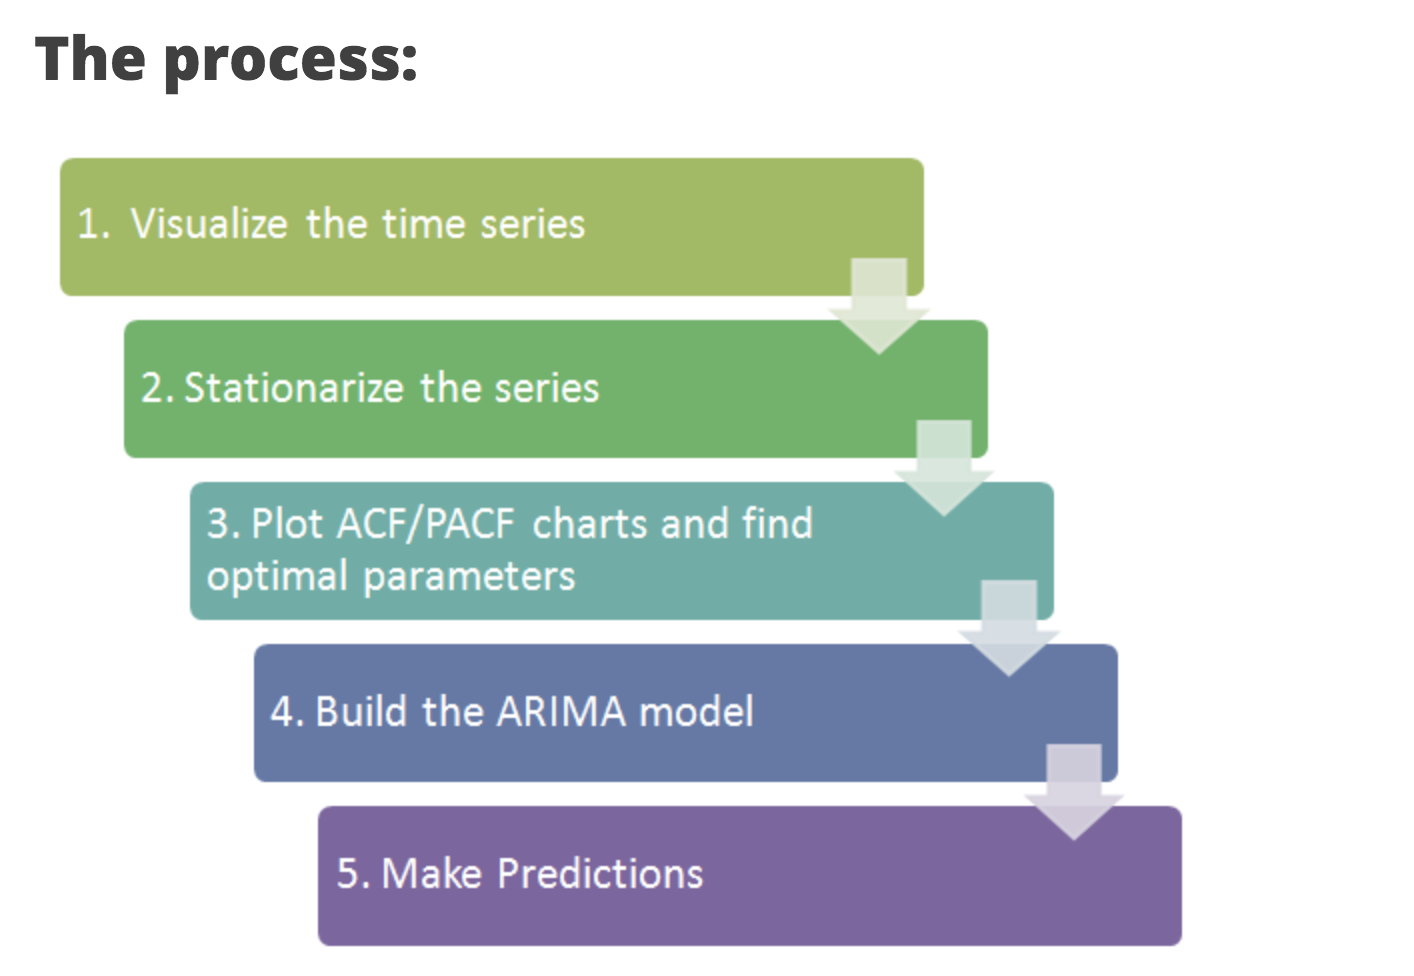

In [1]:
# import relevant module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#import pm_clean from 'pm_clean.csv' file and parse the strings in 'date_time' column into DateTime objects

pm_clean = pd.read_csv('pm_clean.csv',index_col=0, parse_dates=['date_time'])
print(pm_clean.head(1))

   year  month  day  hour  season  dewp  humi    pres  temp cbwd   iws  \
0  2010      1    1    23       4 -17.0  41.0  1020.0  -5.0   CV  0.89   

   precipitation  iprec     city  pm_average           date_time    ws  
0            0.0    0.0  beijing       129.0 2010-01-01 23:00:00  0.89  


In [3]:
# use a subset of one city (city Beijing) to explore for now
bj = pm_clean[pm_clean['city'] == 'beijing']

# set 'date_time' as index and extract the time series 'pm_average' data only
bj_hourly = bj.set_index('date_time')['pm_average']
print(bj_hourly.head())

date_time
2010-01-01 23:00:00    129.0
2010-01-02 00:00:00    148.0
2010-01-02 01:00:00    159.0
2010-01-02 02:00:00    181.0
2010-01-02 03:00:00    138.0
Name: pm_average, dtype: float64


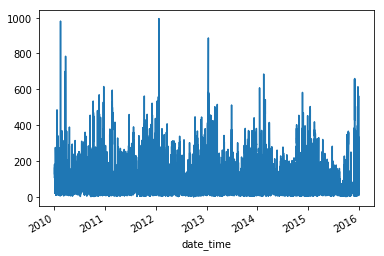

In [4]:
# plot the time series to inspect the features
bj_hourly.plot();

As shown, there is a significant seasonality component in the hourly time series data.
Need to perform the stationary test to see if there's a need for tranforming the data.

### Test for stationarity
In order to use an ARIMA model, the Dickey-Fuller Test is conducted to determine if the time series is stationary (constant mean, variance and autocorrelation across the time series dataset).
 
<li>$H_o$: Non-stationary series
<li>$H_a$: Stationary series

In [5]:
# http://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.stattools.adfuller.html

useful_values_raw = adfuller(bj_hourly, autolag = 'AIC')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%'], 'Value':useful_values})

,Label,Value
0,Test Statistic,-22.578622
1,p-value,0.000000
2,#Lags Used,54.000000
3,Number of Observations Used,49799.000000
4,Critical value for 1%,-3.430481
5,Critical value for 5%,-2.861598
6,Critical value for 10%,-2.566801


p-value is 0.000000, we can reject the null hypothesis of non-stationarity. As the test concludes, the time series pm_average data is already stationary. Therefore, the ARIMA and SARIMA model can be used directly and there is no need for applying the log and difference transformations.

### acf and pacf plots for identifying the model parameters

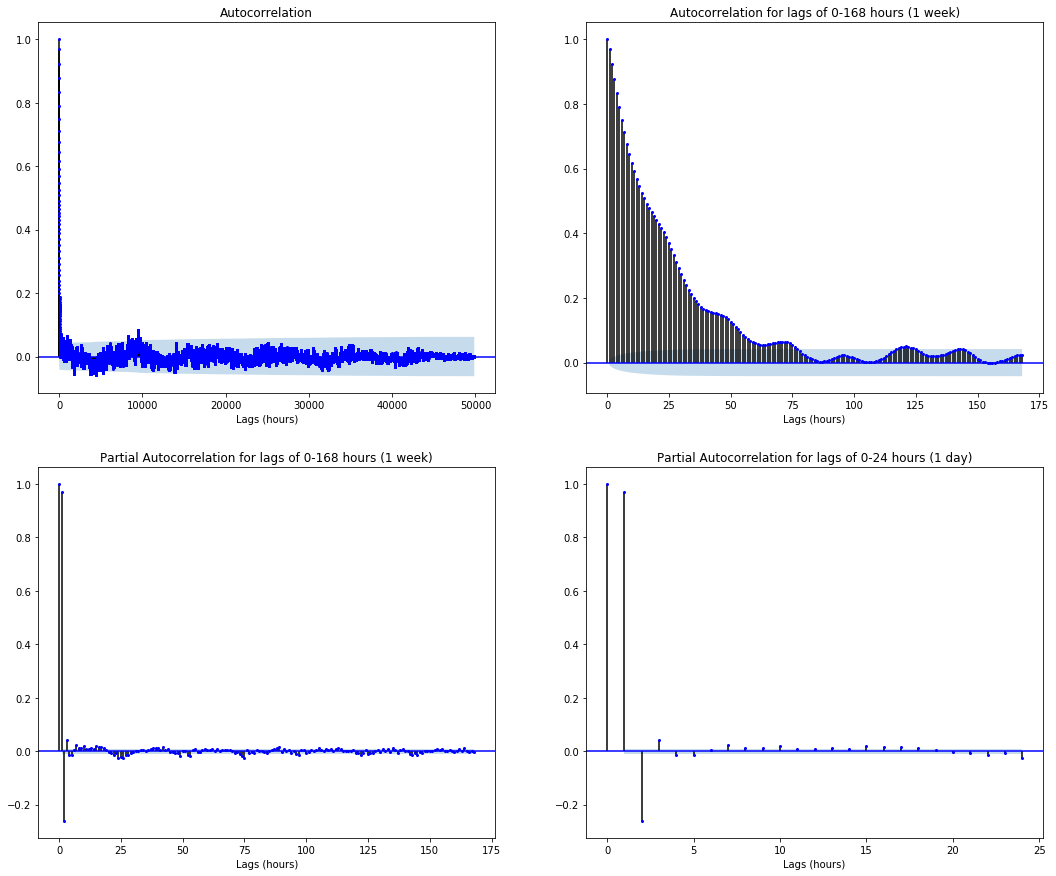

In [6]:
# look at the autocorrelation and partial autocorrelation plots to identify potential structure in the time series data

fig = plt.figure(figsize=(18,15));

ax1 = fig.add_subplot(221)
plot_acf(bj_hourly, ax=ax1, color='blue',markersize=2);
ax1.set_xlabel('Lags (hours)');

ax2 = fig.add_subplot(222)
plot_acf(bj_hourly,lags=168, ax=ax2, title='Autocorrelation for lags of 0-168 hours (1 week)', color='blue',markersize=2);
ax2.set_xlabel('Lags (hours)');

ax3 = fig.add_subplot(223)
plot_pacf(bj_hourly, lags=168, ax=ax3, title='Partial Autocorrelation for lags of 0-168 hours (1 week)', color='blue', markersize=2);
ax3.set_xlabel('Lags (hours)');

ax4 = fig.add_subplot(224)
plot_pacf(bj_hourly, lags=24, ax=ax4, title='Partial Autocorrelation for lags of 0-24 hours (1 day)', color='blue', markersize=2);
ax4.set_xlabel('Lags (hours)');

As the plots and data transformation reveal, the parameters for the ARIMA model should be: 
1. The number of Auto-Regressive Terms based on the pacf plot: p=1 or p=2
2. The number of differences taken given that no data transformation is necessary: d=0
3. The number of Moving Average Terms based on the acf plot: q=0 or q=1

## ARIMA model

In [7]:
# train test split

bj_hourly_train = bj_hourly.loc['2010':'2014']
bj_hourly_test = bj_hourly.loc['2015']
print(len(bj_hourly_train), len(bj_hourly_test))

41892 7962


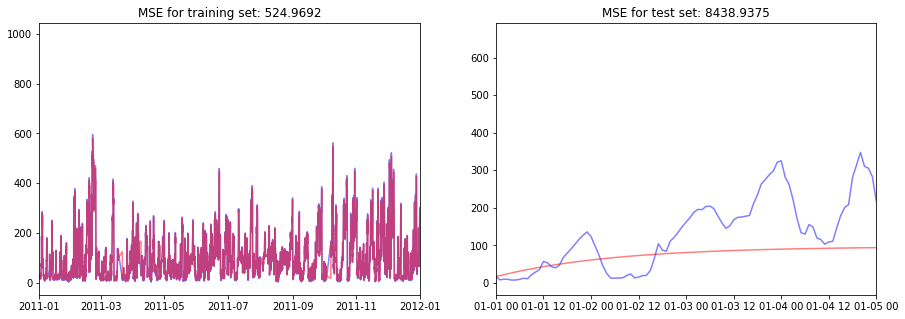

In [8]:
# ARIMA model with p=1, d=0 and q=0
model_1 = ARIMA(bj_hourly_train, order=(1, 0, 0))  
result_1 = model_1.fit()
predict_1 = result_1.predict(start=len(bj_hourly_train), end=len(bj_hourly)-1, dynamic=True)
predict_1.index = bj_hourly_test.index

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(bj_hourly_train, color='blue', alpha=0.5);
ax1.plot(result_1.fittedvalues, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.4f}'.format(np.mean((result_1.fittedvalues-bj_hourly_train)**2)));
ax1.set_xlim(['2011','2012']);

ax2 = fig.add_subplot(122)
ax2.plot(bj_hourly_test, color='blue',alpha=0.5);
ax2.plot(predict_1, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.4f}'.format(np.mean((predict_1-bj_hourly_test)**2)));
ax2.set_xlim(['2015-1-1','2015-1-5']);

In [9]:
comparison = pd.DataFrame({'actual':bj_hourly_test,'predict':predict_1})
print(comparison.head(48))

                         actual    predict
date_time                                 
2015-01-01 00:00:00   16.750000  16.477769
2015-01-01 01:00:00    8.000000  19.116237
2015-01-01 02:00:00    9.500000  21.668328
2015-01-01 03:00:00    9.250000  24.136868
2015-01-01 04:00:00    7.250000  26.524595
2015-01-01 05:00:00    7.500000  28.834152
2015-01-01 06:00:00    9.250000  31.068100
2015-01-01 07:00:00   12.250000  33.228913
2015-01-01 08:00:00   11.000000  35.318986
2015-01-01 09:00:00   21.500000  37.340634
2015-01-01 10:00:00   28.500000  39.296098
2015-01-01 11:00:00   35.250000  41.187545
2015-01-01 12:00:00   57.000000  43.017070
2015-01-01 13:00:00   53.500000  44.786700
2015-01-01 14:00:00   43.250000  46.498397
2015-01-01 15:00:00   40.000000  48.154057
2015-01-01 16:00:00   46.500000  49.755513
2015-01-01 17:00:00   67.500000  51.304542
2015-01-01 18:00:00   79.250000  52.802859
2015-01-01 19:00:00   90.750000  54.252125
2015-01-01 20:00:00  103.000000  55.653944
2015-01-01 

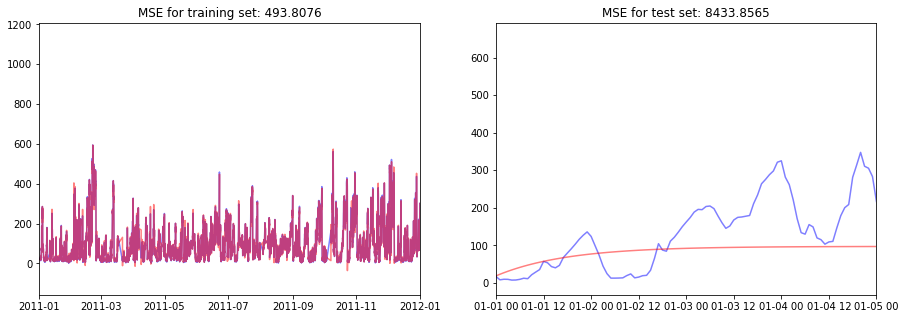

In [10]:
# ARIMA model with p=2, d=0 and q=0

model_2 = ARIMA(bj_hourly_train, order=(2, 0, 0))  
result_2 = model_2.fit(disp=-1)
predict_2 = result_2.predict(start=len(bj_hourly_train), end=len(bj_hourly)-1, dynamic=True)
predict_2.index = bj_hourly_test.index

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(bj_hourly_train, color='blue', alpha=0.5);
ax1.plot(result_2.fittedvalues, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.4f}'.format(np.mean((result_2.fittedvalues-bj_hourly_train)**2)));
ax1.set_xlim(['2011','2012']);

ax2 = fig.add_subplot(122)
ax2.plot(bj_hourly_test, color='blue',alpha=0.5);
ax2.plot(predict_2, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.4f}'.format(np.mean((predict_2-bj_hourly_test)**2)));
ax2.set_xlim(['2015-1-1','2015-1-5']);

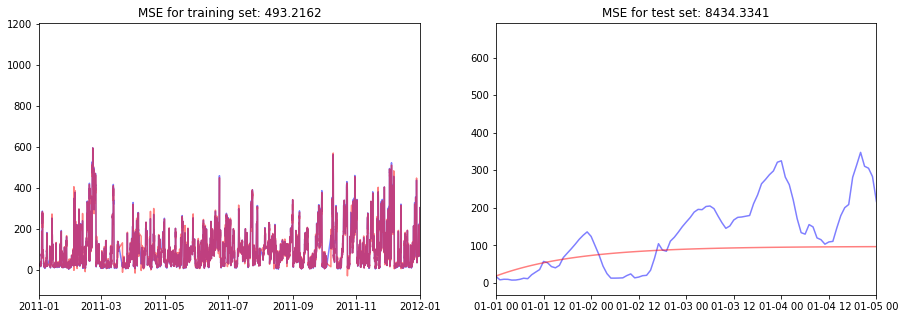

In [11]:
# ARIMA model with p=1, d=0 and q=1

model_3 = ARIMA(bj_hourly_train, order=(1, 0, 1))  
result_3 = model_3.fit(disp=-1)
predict_3 = result_3.predict(start=len(bj_hourly_train), end=len(bj_hourly)-1, dynamic=True)
predict_3.index = bj_hourly_test.index

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(bj_hourly_train, color='blue', alpha=0.5);
ax1.plot(result_3.fittedvalues, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.4f}'.format(np.mean((result_3.fittedvalues-bj_hourly_train)**2)));
ax1.set_xlim(['2011','2012']);

ax2 = fig.add_subplot(122)
ax2.plot(bj_hourly_test, color='blue',alpha=0.5);
ax2.plot(predict_3, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.4f}'.format(np.mean((predict_3-bj_hourly_test)**2)));
ax2.set_xlim(['2015-1-1','2015-1-5']);

                              ARMA Model Results                              
Dep. Variable:             pm_average   No. Observations:                41892
Model:                     ARMA(2, 1)   Log Likelihood             -189316.411
Method:                       css-mle   S.D. of innovations             22.202
Date:                Tue, 11 Sep 2018   AIC                         378642.823
Time:                        22:25:17   BIC                         378686.037
Sample:                             0   HQIC                        378656.471
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               97.1439      2.762     35.177      0.000      91.731     102.557
ar.L1.pm_average     1.0435      0.019     54.030      0.000       1.006       1.081
ar.L2.pm_average    -0.0894 

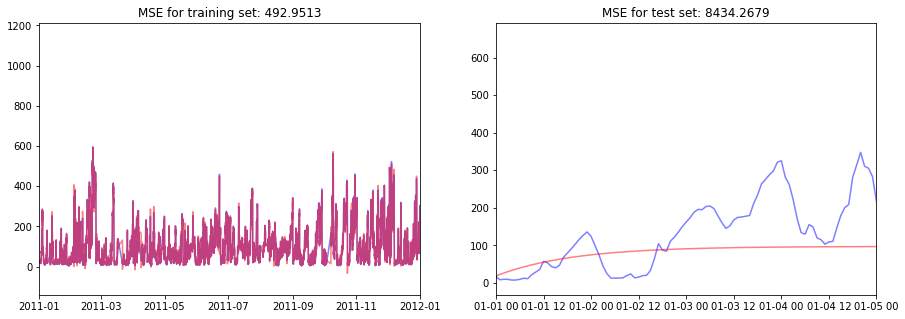

In [12]:
# ARIMA model with p=2, d=0 and q=1

model_4 = ARIMA(bj_hourly_train, order=(2, 0, 1))  
result_4 = model_4.fit(disp=-1)
predict_4 = result_4.predict(start=len(bj_hourly_train), end=len(bj_hourly)-1, dynamic=True)
predict_4.index = bj_hourly_test.index

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(bj_hourly_train, color='blue', alpha=0.5);
ax1.plot(result_4.fittedvalues, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.4f}'.format(np.mean((result_4.fittedvalues-bj_hourly_train)**2)));
ax1.set_xlim(['2011','2012']);

ax2 = fig.add_subplot(122)
ax2.plot(bj_hourly_test, color='blue',alpha=0.5);
ax2.plot(predict_4, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.4f}'.format(np.mean((predict_4-bj_hourly_test)**2)));
ax2.set_xlim(['2015-1-1','2015-1-5']);

print(result_4.summary())

In general, four ARIMA models with various p,d,q combinations share similar performances, with great performance on the training set but very poor performance on the test set. 
Among the four, the model with p=2, d=0 and q=1 achieves slightly better result than the other three. 

## SARIMA model

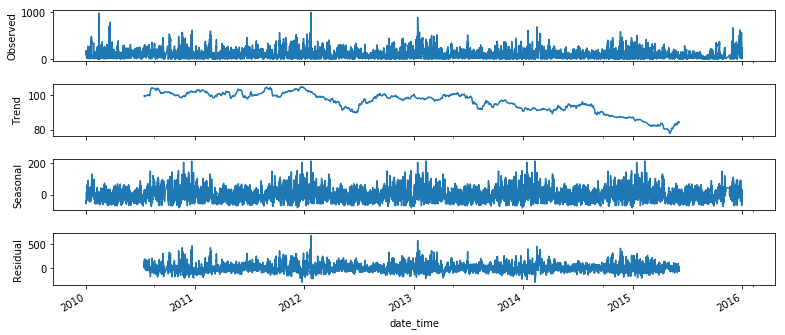

In [13]:
# decomposition
decomposition = seasonal_decompose(bj_hourly, freq=8760) # freq = 1 year
fig = decomposition.plot()
fig.set_size_inches(12, 5);

# # access each component of the decomposition 
# trend = decomposition.trend
# seasonal = decomposition.seasonal 
# residual = decomposition.resid

Decomposition with a frequency of one-year reveals a pronounced seasonality and a downward trend.

In [ ]:
model_5 = SARIMAX(bj_hourly_train, order=(1,0,1), seasonal_order=(0,1,0,24))
result_5 = model_5.fit()
print(result_5.summary());
result_5.plot_diagnostics(figsize=(16,10));

In [ ]:
predict_5 = result_5.predict(start=len(bj_hourly_train), end=len(bj_hourly)-1, dynamic=True)
predict_5.index = bj_hourly_test.index

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(bj_hourly_train, color='blue', alpha=0.5);
ax1.plot(result_5.fittedvalues, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.4f}'.format(np.mean((result_5.fittedvalues-bj_hourly_train)**2)));
ax1.set_xlim(['2011','2012']);

ax2 = fig.add_subplot(122)
ax2.plot(bj_hourly_test, color='blue',alpha=0.5);
ax2.plot(predict_5, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.4f}'.format(np.mean((predict_5-bj_hourly_test)**2)));
ax2.set_xlim(['2015-1-1','2015-1-5']);

In [ ]:
model_6 = SARIMAX(bj_hourly_train, order=(1,0,1), seasonal_order=(0,1,0,8760))
result_6 = model_6.fit()
print(result_6.summary());
result_6.plot_diagnostics(figsize=(16,10));

In [ ]:
predict_6 = result_5.predict(start=len(bj_hourly_train), end=len(bj_hourly)-1, dynamic=True)
predict_6.index = bj_hourly_test.index

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(bj_hourly_train, color='blue', alpha=0.5);
ax1.plot(result_6.fittedvalues, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.4f}'.format(np.mean((result_6.fittedvalues-bj_hourly_train)**2)));
ax1.set_xlim(['2011','2012']);

ax2 = fig.add_subplot(122)
ax2.plot(bj_hourly_test, color='blue',alpha=0.5);
ax2.plot(predict_6, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.4f}'.format(np.mean((predict_6-bj_hourly_test)**2)));
ax2.set_xlim(['2015-1-1','2015-1-5']);